# OGGM Hackaton
**24.10.2018**

What I'm trying to do is to implement the orginal model from Ben's paper into the OGGM workflow.

## Import section

In [1]:
# data management modules
import numpy as np
import xarray as xr
import pandas as pd

# oggm modules
import oggm
from oggm import cfg, utils, tasks, workflow, graphics
from oggm.workflow import execute_entity_task

# plotting modules
import matplotlib.pyplot as plt

# force matplotlib to show figures in notebook
%matplotlib inline

## Checking for modularity...
The OGGM is quite modular on paper. Here I want to see what I get from the existing workflow and where or better with what I have to turn onto a new workflow...

For this reason I use the Upper Grindelwald Glacier, since I'm already working on it.

In [2]:
# Initialize OGGM and set up the run parameters
cfg.initialize()

2019-01-07 14:06:28: oggm.cfg: Parameter file: /Users/oberrauch/oggm/oggm/params.cfg


In [3]:
# Local paths (where to write the OGGM run output)
wdir = '/Users/oberrauch/work/hacktoberfest/test_wd'
utils.mkdir(wdir, reset=True)
cfg.PATHS['working_dir'] = wdir
cfg.PARAMS['use_intersects'] = False

In [4]:
# specify RGI ID for the Upper Grindelwald Glacier (UGG)
rgi_id = 'RGI60-11.01270'
# get RGI entry for the UGG
rgidf = utils.get_rgi_glacier_entities([rgi_id], version='61')
rgidf

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,check_geom,geometry
1269,RGI60-11.01270,G008119E46614N,20030799,20030999,8.11933,46.6143,11,1,9.023,1361,...,6412,0,0,0,0,9,9,None,WARN:WasInvalid;,"POLYGON ((8.127299661000052 46.63327544100008,..."


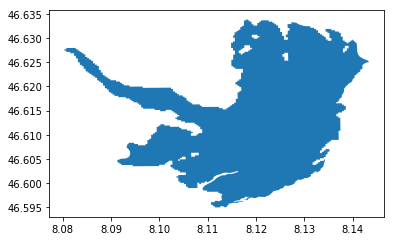

In [5]:
rgidf.plot();

In [6]:
# Go - initialize working directories
gdirs = workflow.init_glacier_regions(rgidf)
# get UGG glacier directory (since I'm working on one glacier only)
gdir = gdirs[0]
# what attributes do we have
gdir

2019-01-07 14:06:30: oggm.workflow: Multiprocessing: using all available processors (N=4)
2019-01-07 14:06:30: oggm.core.gis: (RGI60-11.01270) define_glacier_region


<oggm.GlacierDirectory>
  RGI id: RGI60-11.01270
  Region: 11: Central Europe
  Subregion: 11-01: Alps                            
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 9.023 km2
  Lon, Lat: (8.11933, 46.6143)
  Grid (nx, ny): (132, 123)
  Grid (dx, dy): (52.0, -52.0)

In [7]:
# preprocessing tasks
task_list = [
    tasks.glacier_masks,
    tasks.compute_centerlines,
    tasks.initialize_flowlines,
    tasks.catchment_area,
    tasks.catchment_intersections,
    tasks.catchment_width_geom,
    tasks.catchment_width_correction,
    tasks.compute_downstream_line,
    tasks.compute_downstream_bedshape
]
# execute all tasks
for task in task_list:
    task(gdir)

2019-01-07 14:06:30: oggm.core.gis: (RGI60-11.01270) glacier_masks
2019-01-07 14:06:31: oggm.core.centerlines: (RGI60-11.01270) compute_centerlines
2019-01-07 14:06:31: oggm.core.centerlines: (RGI60-11.01270) initialize_flowlines
2019-01-07 14:06:31: oggm.core.centerlines: (RGI60-11.01270) catchment_area
2019-01-07 14:06:34: oggm.core.centerlines: (RGI60-11.01270) catchment_intersections
2019-01-07 14:06:34: oggm.core.centerlines: (RGI60-11.01270) catchment_width_geom
2019-01-07 14:06:35: oggm.core.centerlines: (RGI60-11.01270) catchment_width_correction
2019-01-07 14:06:35: oggm.core.centerlines: (RGI60-11.01270) compute_downstream_line
2019-01-07 14:06:35: oggm.core.centerlines: (RGI60-11.01270) compute_downstream_bedshape


In [8]:
# use the OGGM climate task to process the climate
tasks.process_cru_data(gdir)

2019-01-07 14:06:36: oggm.core.climate: (RGI60-11.01270) process_cru_data


2019-01-07 14:06:40: oggm.core.climate: (RGI60-11.01270) glacier_mu_candidates


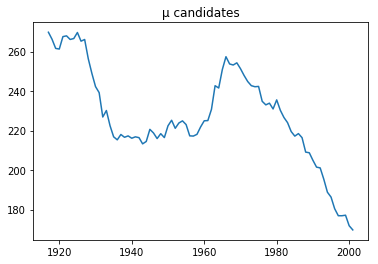

In [9]:
tasks.glacier_mu_candidates(gdir)
mu_candidates = gdir.read_pickle('climate_info')['mu_candidates_glacierwide']
mu_candidates.plot(title='µ candidates');

In [10]:
# set t* and compute mu* for UGG
tasks.local_t_star(gdir)
tasks.mu_star_calibration(gdir)

2019-01-07 14:06:40: oggm.core.climate: (RGI60-11.01270) local_t_star
2019-01-07 14:06:40: oggm.core.climate: (RGI60-11.01270) local mu* for t*=1952
2019-01-07 14:06:40: oggm.core.climate: (RGI60-11.01270) mu_star_calibration


In [11]:
gdir.read_json('local_mustar')

{'rgi_id': 'RGI60-11.01270',
 't_star': 1952,
 'bias': 6.194361372145723,
 'mu_star_glacierwide': 221.13964355821986,
 'mu_star_per_flowline': [221.1396435582199,
  221.1396435582199,
  221.1396435582199,
  221.1396435582199],
 'mu_star_flowline_avg': 221.1396435582199,
 'mu_star_allsame': True}

In [12]:
# inversion tasks
tasks.prepare_for_inversion(gdir)
tasks.mass_conservation_inversion(gdir)
tasks.filter_inversion_output(gdir)

2019-01-07 14:06:41: oggm.core.inversion: (RGI60-11.01270) prepare_for_inversion
2019-01-07 14:06:41: oggm.core.inversion: (RGI60-11.01270) mass_conservation_inversion
2019-01-07 14:06:41: oggm.core.inversion: (RGI60-11.01270) filter_inversion_output


## µ* computation

In [13]:
# load the new module
import importlib
from oggm.core import climate
from oggm.core import ben
importlib.reload(climate)
importlib.reload(ben)

<module 'oggm.core.ben' from '/Users/oberrauch/oggm/oggm/core/ben.py'>

In [75]:
# interpolate the local t* and
# compute the corresponding µ*
ben.local_t_star(gdir)

In [15]:
ben_params = gdir.read_json('ben_params')
ben_params

{'rgi_id': 'RGI60-11.01270',
 't_star': 1952,
 'bias': 6.194361372145723,
 'mu_star': 26.856490036860997}

In [16]:
gdir.read_json('local_mustar')

{'rgi_id': 'RGI60-11.01270',
 't_star': 1952,
 'bias': 6.194361372145723,
 'mu_star_glacierwide': 221.13964355821986,
 'mu_star_per_flowline': [221.1396435582199,
  221.1396435582199,
  221.1396435582199,
  221.1396435582199],
 'mu_star_flowline_avg': 221.1396435582199,
 'mu_star_allsame': True}

## The past mass balance model

In [17]:
# load the OGGM mass balance module
import importlib
from oggm.core import massbalance, ben
importlib.reload(ben)

<module 'oggm.core.ben' from '/Users/oberrauch/oggm/oggm/core/ben.py'>

First thing I did is to copy the existing ``PastMassBalance`` model, since it is based on the original mass balance model. But then, calling ``massbalance.OriginalMassBalance(gdir)`` results in an error. The problem is that the ``local_mustar`` file is not available. The same happens for the ``PastMassBalance`` (most obviously). So some (climate) calibration step is missing...

EDIT: now I'm missing the ``mb_calib_params`` in the ``climate_info`` file.

EDIT 2: Turns out, I'm an idiot!

In [18]:
years = np.arange(1915, 2012)
heights = np.linspace(2500, 3500, 21)

In [19]:
fls = gdir.read_pickle('inversion_flowlines')
heights = [fl.surface_h for fl in fls]
widths = [fl.widths for fl in fls]

In [20]:
# create instances of the mass balance model
past_mbmod = massbalance.PastMassBalance(gdir)
past_mb = list()
for i, fl in enumerate(fls):
    # compute monthly mb with PastMassBalance model
    past_mb_tmp = [past_mbmod.get_specific_mb(heights=heights[i], widths=widths[i], year=year) for year in years]
    past_mb.append(past_mb_tmp)

In [21]:
mb_specific = past_mbmod.get_specific_mb(fls=fls, year=years)

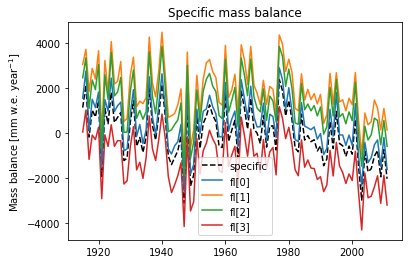

In [22]:
plt.plot(years, mb_specific, 'k--', label='specific')

for i, past_mb_tmp in enumerate(past_mb):
    plt.plot(years, past_mb_tmp, label='fl[{}]'.format(i))

plt.title('Specific mass balance')
plt.ylabel('Mass balance [mm w.e. year$^{-1}$]')
plt.legend();

## The new (simpler) mass balance model

In [23]:
# load the OGGM mass balance module
import importlib
from oggm.core import massbalance, ben
importlib.reload(ben)

<module 'oggm.core.ben' from '/Users/oberrauch/oggm/oggm/core/ben.py'>

In [73]:
# omit bias
cfg.PARAMS['use_bias_for_run'] = False

# create instances of the mass balance model
ben_mbmod = ben.BenMassBalance(gdir)

In [52]:
# the following function is now included of the ben.py file
from oggm.utils import ncDataset

def get_min_max_elevation(gdir):
    # get relevant elevation information
    fpath = gdir.get_filepath('gridded_data')
    with ncDataset(fpath) as nc:
        mask = nc.variables['glacier_mask'][:]
        topo = nc.variables['topo'][:]
    min_elev = np.min(topo[np.where(mask == 1)])
    max_elev = np.max(topo[np.where(mask == 1)])
    return min_elev, max_elev

In [53]:
# get minimal and maximal glacier surface elevation
min_hgt, max_hgt = ben.get_min_max_elevation(gdir)
get_min_max_elevation(gdir)

(1366.0, 3712.0)

In [54]:
import calendar

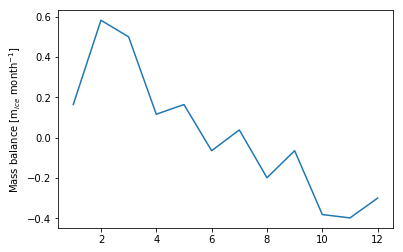

In [55]:
year = 1953
months = np.arange(12)+1
months_names = [calendar.month_name]
years = np.linspace(year, year+1, 12, endpoint=False)
# compute monthly mb for given hydrological year
mb = [ben_mbmod.get_monthly_mb(min_hgt, max_hgt, year=year)*cfg.SEC_IN_MONTH for year in years]
plt.plot(months, mb)

plt.ylabel('Mass balance [m$_{ice}$ month$^{-1}$]');

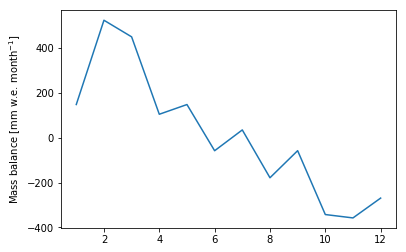

In [74]:
year = 1953
months = np.arange(12)+1
months_names = [calendar.month_name]
years = np.linspace(year, year+1, 12, endpoint=False)
# compute monthly mb for given hydrological year
mb = [ben_mbmod.get_monthly_specific_mb(min_hgt, max_hgt, year=year) for year in years]
plt.plot(months, mb)

plt.ylabel('Mass balance [mm w.e. month$^{-1}$]');

In [56]:
# compute annual mb for given years
years = np.arange(1915, 2012)

mb_ben = [ben_mbmod.get_annual_mb(min_hgt, max_hgt, year=year)*cfg.SEC_IN_YEAR*ben_mbmod.rho for year in years]

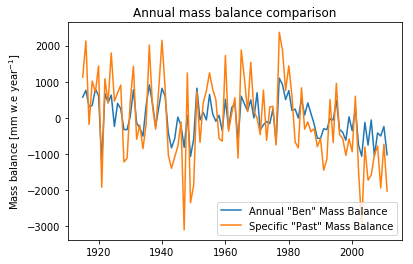

In [57]:
#
plt.plot(years, mb_ben, label='Annual "Ben" Mass Balance')
plt.plot(years, mb_specific, label='Specific "Past" Mass Balance')
plt.legend()
plt.ylabel('Mass balance [mm w.e year$^{-1}$]')
plt.title('Annual mass balance comparison');

plt.savefig('../text/img/mb_time_series.png', bbox_inches='tight')

In [58]:
from scipy.stats import linregress
lin_reg = linregress(mb_specific, mb_ben)
lin_reg

LinregressResult(slope=0.3927446309113738, intercept=28.446640241347488, rvalue=0.870841861459007, pvalue=4.684103274975825e-31, stderr=0.02274513844677837)

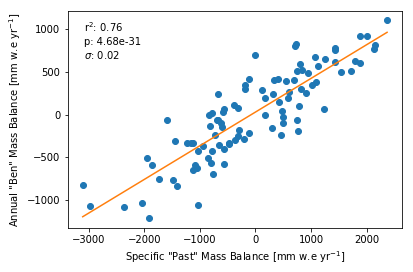

In [59]:
plt.plot(mb_specific, mb_ben, ls='None', marker='o')
plt.xlabel('Specific "Past" Mass Balance [mm w.e yr$^{-1}$]')
plt.ylabel('Annual "Ben" Mass Balance [mm w.e yr$^{-1}$]')
# add linear regression
x = np.linspace(min(mb_specific), max(mb_specific))
y = x*lin_reg.slope + lin_reg.intercept
plt.plot(x,y)
plt.text(0.05, 0.9, 'r$^2$: {:.2f}'.format(lin_reg.rvalue**2), transform=plt.gca().transAxes)
plt.text(0.05, 0.84, 'p: {:.2e}'.format(lin_reg.pvalue), transform=plt.gca().transAxes)
plt.text(0.05, 0.78, '$\sigma$: {:.2f}'.format(lin_reg.stderr), transform=plt.gca().transAxes)

plt.savefig('../text/img/mb_scatter.png', bbox_inches='tight')

Testing the specific mass balance over the climate period

In [60]:
# Check for apparent mb to be zeros
# ---------------------------------

# define 31-year climate period around t*
t_star = ben_params['t_star']
mu_hp = int(cfg.PARAMS['mu_star_halfperiod'])
years = np.arange(t_star-mu_hp, t_star+mu_hp+1)
# iterate over all years in climate period
# and sum specific mass balance
mbs = np.empty(years.size)
for i, year in enumerate(years):
    mbs[i] = ben_mbmod.get_specific_mb(min_hgt, max_hgt, year)
    
print('Sum over climate period: {:.0f} mm w.e. year'.format(mbs.sum()))

Sum over climate period: 0 mm w.e. year


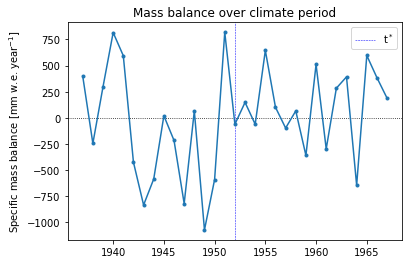

In [68]:
# aux line
plt.axhline(0, c='k', ls=':', lw=0.8)
plt.axvline(t_star, c='b', ls='--', lw=0.5, label='t$^*$')

# visualize mass balance
plt.plot(years, mbs, marker='.')
plt.ylabel('Specific mass balance [mm w.e. year$^{-1}$]')
plt.title('Mass balance over climate period')

# legend
plt.legend()

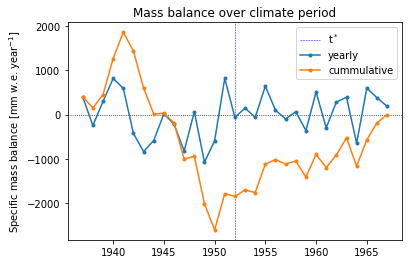

In [69]:
# aux line
plt.axhline(0, c='k', ls=':', lw=0.8)
plt.axvline(t_star, c='b', ls='--', lw=0.5, label='t$^*$')

# plot mass balance
plt.plot(years, mbs, label='yearly', marker='.')
plt.plot(years, mbs.cumsum(), label='cummulative',  marker='.')
plt.ylabel('Specific mass balance [mm w.e. year$^{-1}$]')
plt.title('Mass balance over climate period')

# legend
plt.legend()